<a href="https://colab.research.google.com/github/FranciscaAlliende/APS-Failure-at-Scania-Trucks/blob/master/SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [3]:
# setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import mean
import imblearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
# my libraries 
import basic_prepro as bp
import null_values as nv
import evaluation_metrics as em

In [4]:
# load data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_training_set.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_test_set.csv')

In [5]:
# basic prepocessing
# replace in class column: pos = 1; neg = 0
# replace the na and nan values with np.NaN
train = bp.data_prepro(train)
test = bp.data_prepro(test)

In [6]:
# null values
# drop the features with more than t% of null values on the train set 
# fill the remaining null values with the median of the corresponding feature with SimpleImputer(strategy = "median").
[y_train, X_train, y_test, X_test] = nv.null_values(train, test, t=0.5)

In [7]:
# choosing the number of neighbors k
# divide de test set into validation and test
X_test2, X_val, y_test2, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=333)

print(X_val.shape)
print(y_val.shape)
print(X_test2.shape)
print(y_test2.shape)

(5280, 162)
(5280,)
(10720, 162)
(10720,)


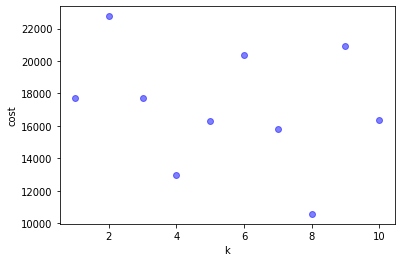

In [8]:
k_values = range(1,11)
costs = []

for k in k_values:
  # oversample
  over = SMOTE(sampling_strategy=0.6, k_neighbors=k) 
  X_res, y_res = over.fit_resample(X_train, y_train)

  # undersample
  under = RandomUnderSampler(sampling_strategy=0.8)
  X_train_up, y_train_up = under.fit_resample(X_res, y_res) 

  # define classifier
  clf = DecisionTreeClassifier()

  # traine
  clf.fit(X_train_up, y_train_up.values)
  
  # predict
  y_pred = clf.predict(X_val)

  # evaluate
  tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
  c1 = 10
  c2 = 500
  cost = c1*fp + c2*fn
  costs.append(cost)

# plot
plt.scatter(k_values, costs, c="b", alpha=0.5)
plt.xlabel("k")
plt.ylabel("cost")
plt.show()
print(zip(k_values, costs))

In [9]:
# Transform the training set
# oversample
k = costs.index(min(costs)) + 1
over = SMOTE(sampling_strategy=0.6, k_neighbors=k) 
X_res, y_res = over.fit_resample(X_train, y_train)
print("original")
print(y_train.value_counts())
print("after oversampling")
print(y_res.value_counts())
# undersampling
under = RandomUnderSampler(sampling_strategy=0.8)
X_train_up, y_train_up = under.fit_resample(X_res, y_res) 
print("after undersampling (final)")
print(y_train_up.value_counts())

original
0    59000
1     1000
Name: class, dtype: int64
after oversampling
0    59000
1    35400
Name: class, dtype: int64
after undersampling (final)
0    44250
1    35400
Name: class, dtype: int64


In [10]:
# check
print(X_train.shape)
print(X_train_up.shape)
print(y_train.shape)
print(y_train_up.shape)

(60000, 162)
(79650, 162)
(60000,)
(79650,)


Total cost: 18700
False positives:  120
False negatives:  35
Confusion matrix, without normalization


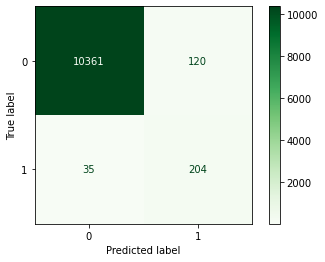

     Normalized confusion matrix


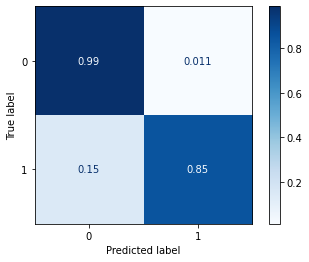

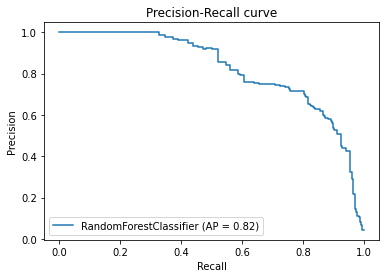

f1 score 0.725
precision:  0.63
recall 0.854


(18700, 0.724689165186501, 0.6296296296296297, 0.8535564853556485)

In [11]:
# RF
clf_RF = RandomForestClassifier(random_state=333)
# training 
clf_RF.fit(X_train_up, y_train_up.values)
# prediction
y_pred_RF = clf_RF.predict(X_test2)
# evaluation
em.evaluation_metrics(y_pred_RF, y_test2, X_test2, clf_RF, c1=10, c2=500)

Total cost: 17860
False positives:  286
False negatives:  30
Confusion matrix, without normalization


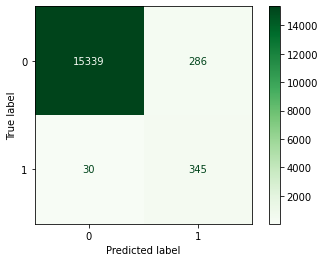

     Normalized confusion matrix


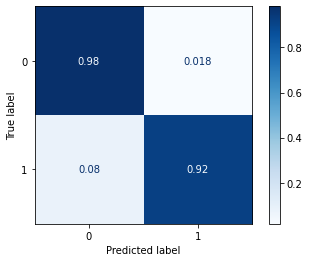

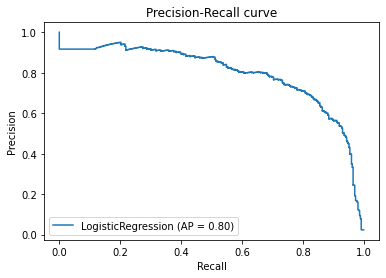

f1 score 0.686
precision:  0.547
recall 0.92


(17860, 0.6858846918489065, 0.5467511885895404, 0.92)

In [12]:
# LR
clf_LR = LogisticRegression(max_iter=1000, solver='liblinear')
# training 
clf_LR.fit(X_train_up, y_train_up.values)
# prediction
y_pred_LR = clf_LR.predict(X_test)
# evaluation
em. evaluation_metrics(y_pred_LR, y_test, X_test, clf_LR, c1=10, c2=500)

Total cost: 13000
False positives:  400
False negatives:  18
Confusion matrix, without normalization


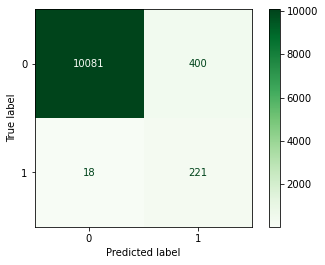

     Normalized confusion matrix


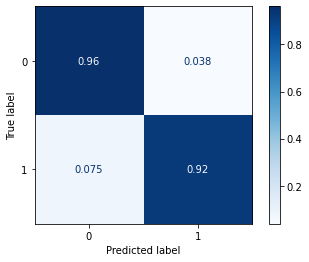

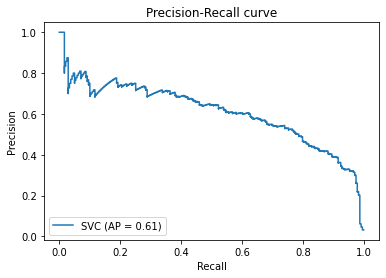

f1 score 0.514
precision:  0.356
recall 0.925


(13000, 0.513953488372093, 0.355877616747182, 0.9246861924686193)

In [13]:
# SVM
clf_SVM = svm.SVC()
# training 
clf_SVM.fit(X_train_up, y_train_up.values)
# prediction
y_pred_SVM = clf_SVM.predict(X_test2)
# evaluation
em. evaluation_metrics(y_pred_SVM, y_test2, X_test2, clf_SVM, c1=10, c2=500)